For now I only did standard stuff and used the new suggested learning rate methods of the 1 cycle learning policy as described here:
    
1. [blog post by Sylvain Gugger summarizing the following papers](https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy)
2. [original papers by leslie smith on hyperparameter tuning](https://arxiv.org/pdf/1803.09820.pdf) 
3. [ and Superconvergence, the 1 cycle policy learning](https://arxiv.org/pdf/1708.07120.pdf)

Next things I planned would be to properly crop the images so it only includes the 32x32 sized patch that is the important part of the image, and check the augmentation settings.
I already set up some functionality to use hyperopt to optimiize the hyperparameters of the one cycle parameters, this will come in another kernel.
I also still need to check how many augmentation in the TTA  as used [here](https://towardsdatascience.com/augmentation-for-image-classification-24ffcbc38833)

I would also like check how the accuracy (or in this case ROC-AUC) changes with the different resnet18/34/50

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import os
from sklearn.metrics import f1_score

from fastai import *
from fastai.vision import *

import torch
import torch.nn as nn
import torchvision
import cv2

from tqdm import tqdm
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload

Defining a metric so after epoch I get the validation ROC-AUC score

In [2]:
model_path='.'
path='../input/'
train_folder=f'{path}train'
test_folder=f'{path}test'
train_lbl=f'{path}train_labels.csv'
ORG_SIZE=96

bs=64
num_workers=None # Apprently 2 cpus per kaggle node, so 4 threads I think
sz=96

In Case I want to run quick tests use a subsample:

In [3]:
df_trn=pd.read_csv(train_lbl)

In [4]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=.0, max_zoom=.1,
                      max_lighting=0.05, max_warp=0.)

In [5]:
data = ImageDataBunch.from_csv(path,csv_labels=train_lbl,folder='train', ds_tfms=tfms, size=sz, suffix='.tif',test=test_folder,bs=bs);
stats=data.batch_stats()        
data.normalize(stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 1, Category 0, Category 0, Category 0, Category 1]...
Path: ../input
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Valid: LabelList
y: CategoryList (44005 items)
[Category 1, Category 1, Category 0, Category 1, Category 0]...
Path: ../input
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input;

Test: LabelList
y: CategoryList (57458 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: ../input
x: ImageItemList (57458 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: ../input

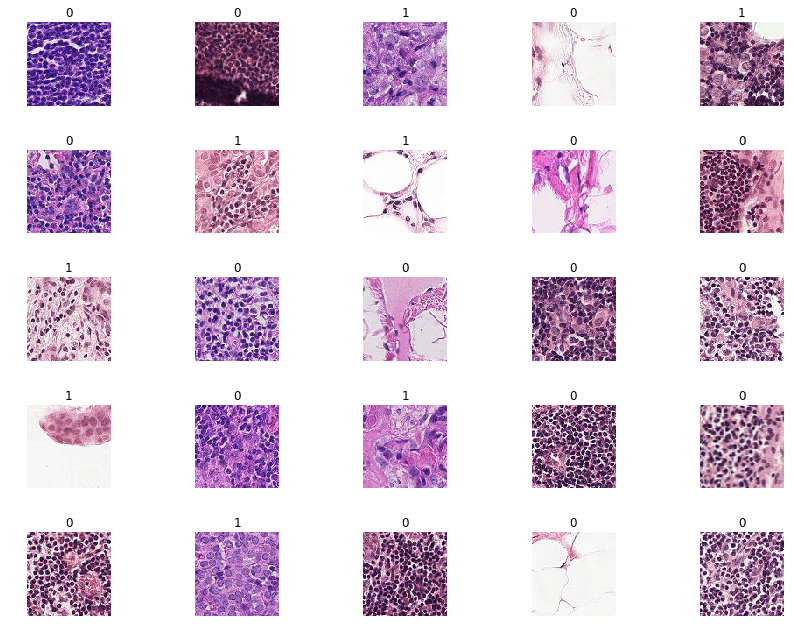

In [6]:
data.show_batch(rows=5, figsize=(12,9))

In [7]:
from sklearn.metrics import roc_auc_score

In [8]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [9]:
from torchvision.models import *

In [10]:
learn = create_cnn(
    data,
    densenet201,
    path='.',    
    metrics=[auc_score], 
    ps=0.5
)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /tmp/.torch/models/densenet201-c1103571.pth
100%|██████████| 81131730/81131730 [07:30<00:00, 179972.03it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


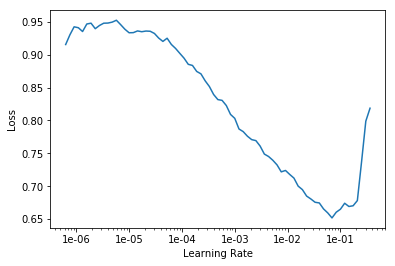

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
lr = 1e-04

epoch,train_loss,valid_loss,auc_score
1,0.243188,0.201428,0.966925


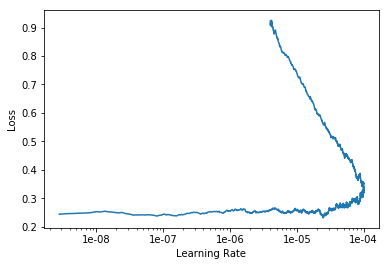

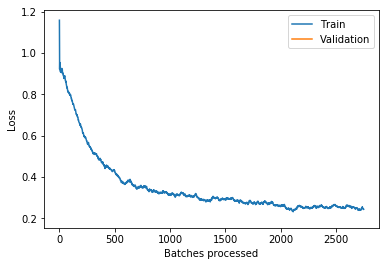

In [13]:
learn.fit_one_cycle(1,lr)
learn.recorder.plot()
learn.recorder.plot_losses()

In [14]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


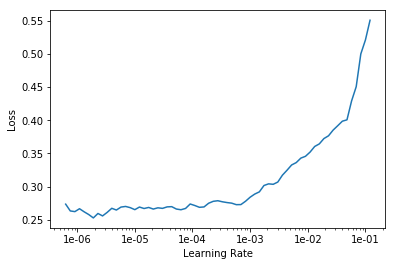

In [15]:
learn.recorder.plot()

### Warm up with frozen weight is done on a subset so we dont have to waste an entire epoch

In [16]:
learn.fit_one_cycle(10,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,auc_score
1,0.187085,0.145049,0.982348


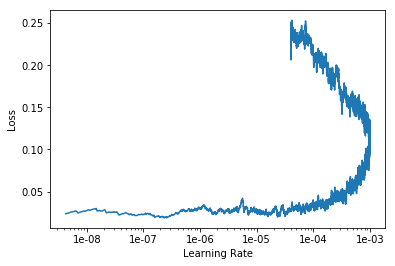

In [17]:
learn.recorder.plot()

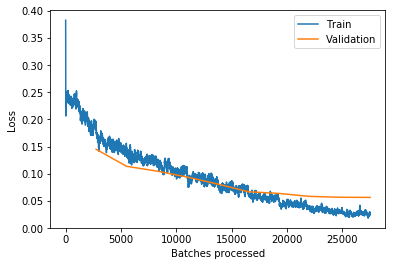

In [18]:
learn.recorder.plot_losses()

### Predit the validation data using TTA
Here for every image we want to predict on, n_augs images are augmented form the original image.
We can then compare the predictions on for example the image and the image flipped / roated / slightly different crop/ lighting/stretched etc. 
For now only the diherdral and rotations are used. THis gives a nice extra percent or two when compared to the auc above after training where not TTA is used. 
I also test if mean or max is better to use on the image and its augments but it can't conclude anything yet.

In [19]:
preds,y=learn.get_preds()
pred_score=auc_score(preds,y)
pred_score

tensor(0.9978)

In [20]:
preds,y=learn.TTA()
pred_score_tta=auc_score(preds,y)
pred_score_tta

### Now predict on test set

In [21]:
preds_test,y_test=learn.get_preds(ds_type=DatasetType.Test)

In [22]:
preds_test_tta,y_test_tta=learn.TTA(ds_type=DatasetType.Test)

### prepare submission
I now load in the sample submission and put my predictions in the label column and save to a new file.

Sometimes its important in which order the ids in the submissions are so to make sure I don't mess up I put them in the same order. My first submission had a 50% score so I somewhere messed up the order oder the matching of id to label.
since fname_clean is the id we can just use that as index when adding the correct label in our dataframe. 

In [23]:
sub=pd.read_csv(f'{path}/sample_submission.csv').set_index('id')
sub.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [24]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned=clean_fname(data.test_ds.items)
fname_cleaned=fname_cleaned.astype(str)

## I add the score to the name of the file so I can later plot the leaderboard score versus my validation score
In the fastai course Jeremy mentions that if you have a monotonic relation between validation and LB score the way you set up your validation set matches what the test set consists of.

In [25]:
sub.loc[fname_cleaned,'label']=to_np(preds_test[:,1])
sub.to_csv(f'submission_{pred_score}.csv')

In [26]:
sub.loc[fname_cleaned,'label']=to_np(preds_test_tta[:,1])
sub.to_csv(f'submission_{pred_score_tta}.csv')